![](https://i.imgur.com/qkg2E2D.png)

# UnSupervised Learning Methods

## Exercise 004 - Part IV

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 09/09/2023 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/UnSupervisedLearningMethods/2023_08/Exercise0004Part004.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, TSNE
from sklearn.metrics import pairwise_distances
# from umap import UMAP
import umap.umap_ as umap

# Computer Vision

# Miscellaneous
import os
import math
from platform import python_version
import random
import time
import urllib.request

# Typing
from typing import Callable, List, Tuple, Union

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image, display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout


## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

In [2]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

In [3]:
# Constants

DATA_FILE_URL   = r'https://drive.google.com/uc?export=download&confirm=9iBg&id=1UXLdZgXwClgwZVszRq88UaaN2nvgMFiC'
DATA_FILE_NAME  = r'BciData.npz'

TOTAL_RUN_TIME = 90 #<! Don't touch it!


In [4]:
# Auxiliary Functions

def Plot2DScatter(mX: np.ndarray, hA: plt.Axes, vC: np.ndarray = None) -> None:
    m = mX.min()
    M = mX.max()
    if vC is not None:
        hA.scatter(*mX.T, s = 50,  c = vC, edgecolor = 'k', alpha = 1)
    else:
        hA.scatter(*mX.T, s = 50,  c = 'lime', edgecolor = 'k', alpha = 1)
    hA.set_xlim([m, M])
    hA.set_ylim([m, M])
    hA.set_xlabel('$x_1$')
    hA.set_ylabel('$x_2$')


def PlotLabelsHistogram(vY: np.ndarray, hA = None, lClass = None, xLabelRot: int = None) -> plt.Axes:

    if hA is None:
        hF, hA = plt.subplots(figsize = (8, 6))
    
    vLabels, vCounts = np.unique(vY, return_counts = True)

    hA.bar(vLabels, vCounts, width = 0.9, align = 'center')
    hA.set_title('Histogram of Classes / Labels')
    hA.set_xlabel('Class')
    hA.set_ylabel('Number of Samples')
    hA.set_xticks(vLabels)
    if lClass is not None:
        hA.set_xticklabels(lClass)
    
    if xLabelRot is not None:
        for xLabel in hA.get_xticklabels():
            xLabel.set_rotation(xLabelRot)

    return hA


In [5]:
# Run Time
print(f'The total run time must not exceed: {TOTAL_RUN_TIME} [Sec]')
startTime = time.time()

The total run time must not exceed: 90 [Sec]


* <font color='brown'>(**#**)</font> The `Import Packages` section above imports most needed tools to apply the work. Please use it.
* <font color='brown'>(**#**)</font> You may replace the suggested functions to use with functions from other packages.
* <font color='brown'>(**#**)</font> Whatever not said explicitly to implement maybe used by a 3rd party packages.

## Team Members

 - `Ori_Blanka_208994764`.
 - `Or_Benson_308577345`.
 - `Alon_Hertz_315682773`

In [6]:
# Students Packages to Import
# If you need a package not listed above, use this cell
# Do not use `pip install` in the submitted notebook
from scipy.linalg import eigvalsh
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut

## Generate / Load Data

In [7]:
# Download Data
# This section downloads data from the given URL if needed.

if (DATA_FILE_NAME != 'None') and (not os.path.exists(DATA_FILE_NAME)):
    urllib.request.urlretrieve(DATA_FILE_URL, DATA_FILE_NAME)

## 9. T-SNE and UMAP

In this section we'll use the _t-SNE_ and _UMAP_ algorithms to analyze EEG Signals in the context of _Brain Computer Interface_ (BCI).  

### The BCI Data Set

The Brain Computer Interfaces (BCI) Data from [BCI Competition IV](https://www.bbci.de/competition/iv/).  
Specifically we'll use [data set 2a](https://www.bbci.de/competition/iv/#dataset2a) provided by the Institute for Knowledge Discovery (Laboratory of Brain Computer Interfaces), Graz University of Technology, (Clemens Brunner, Robert Leeb, Gernot Müller-Putz, Alois Schlögl, Gert Pfurtscheller).  
This is a recording of EEG signals while the subject is doing a cued movement of the left hand, right hand, feet or tongue.

The data is composed of:

 * 22 EEG channels (0.5-100Hz; notch filtered).
 * Sampling Rate of 250 [Hz] for 4 [Sec] for total of 1000 samples.
 * 4 classes: _left hand_, _right hand_, _feet_, _tongue_.
 * 9 subjects.
 * 287 measurements.

</br>

* <font color='brown'>(**#**)</font> You should install [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html) on your system. 

In [8]:
# Generate Data

dData = np.load(DATA_FILE_NAME)
mX    = dData['mX1']
vY    = dData['vY1']

# Sample: An observation of a subject.
# Measurement: Sample in time of the EEG signal.
# Channel: EEG Channel.
numSamples, numMeasurements, numChannels = mX.shape 
lLabel = ['Left Hand', 'Right Hand', 'Foot', 'Tongue'] #<! The labels

print(f'The data shape: {mX.shape}')
print(f'The number of samples: {mX.shape[0]}')
print(f'The number of measurements per sample: {mX.shape[1]}')
print(f'The number of EEG channels: {mX.shape[2]}')
print(f'The classes labels: {np.unique(vY)}')

The data shape: (287, 1000, 22)
The number of samples: 287
The number of measurements per sample: 1000
The number of EEG channels: 22
The classes labels: [0 1 2 3]


* <font color='brown'>(**#**)</font> In the above `sample` is used per object detected.
* <font color='brown'>(**#**)</font> In the above `measurement` is used to describe the time sample (Like in Signal Processing).

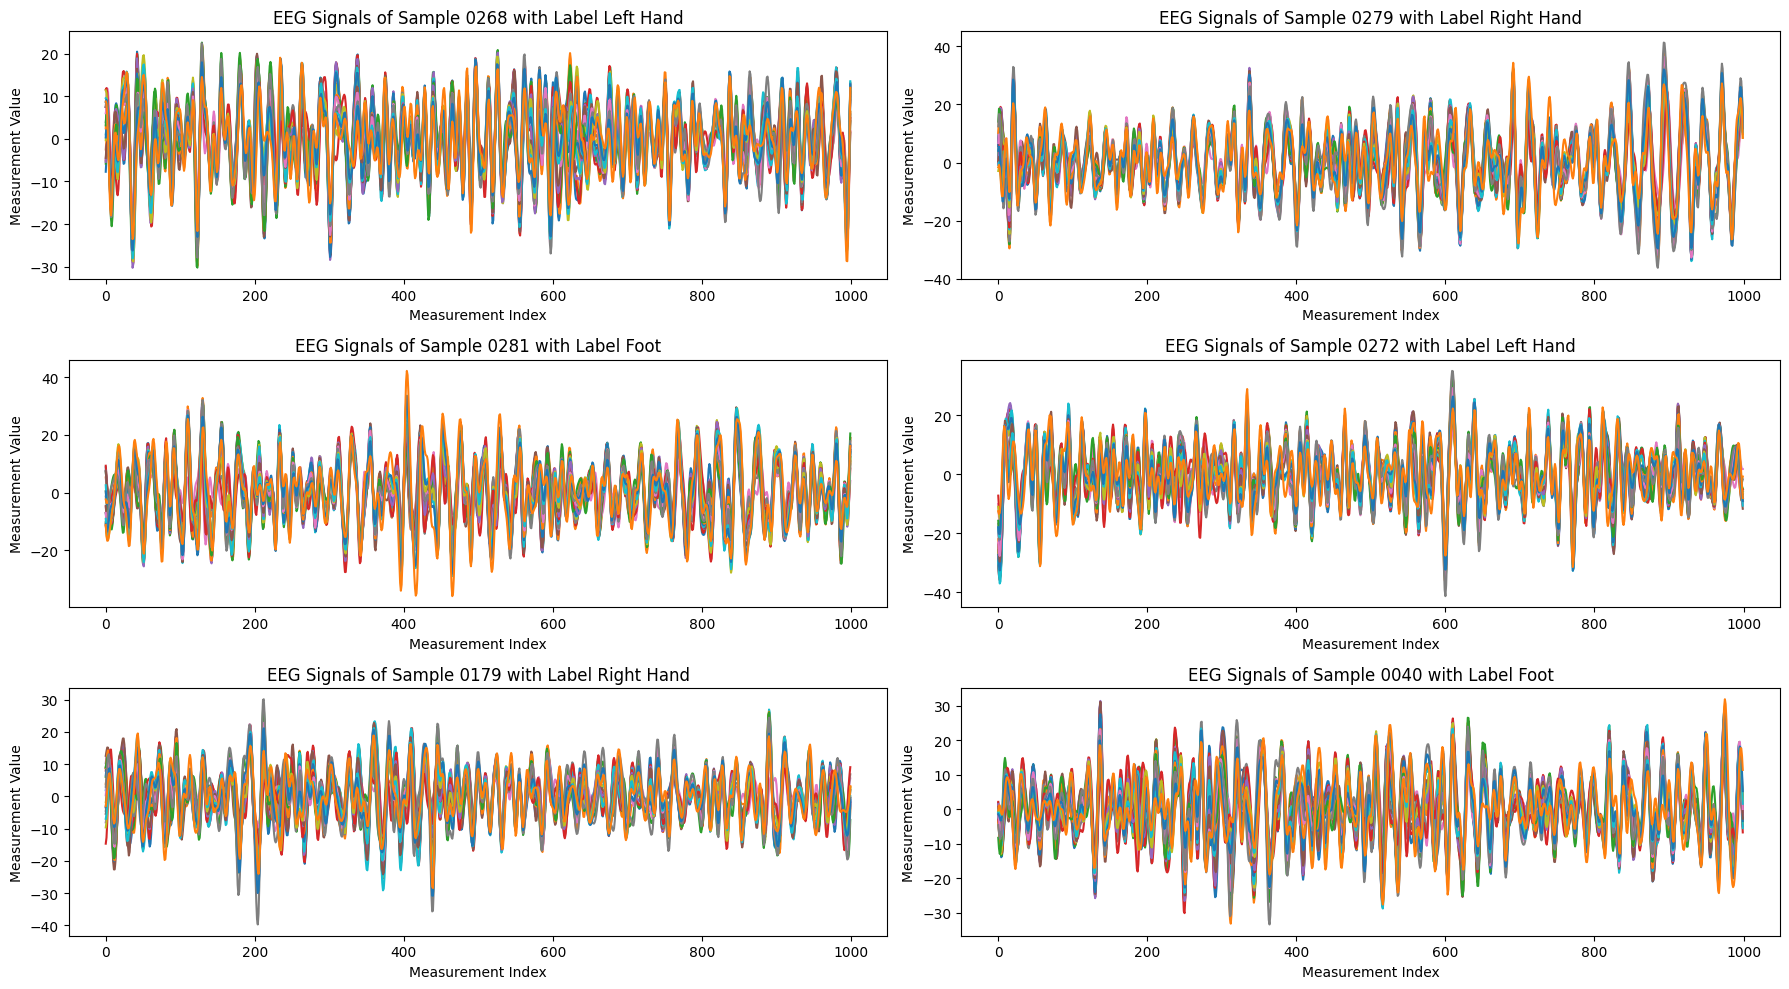

In [9]:
# Plot the Data

numRowsPlot = 3
numColsPlot = 2

numPlots = numRowsPlot * numColsPlot

hF, hAs = plt.subplots(nrows = numRowsPlot, ncols = numColsPlot, figsize = (18, 10))
hAs = hAs.flat

vIdx = np.random.choice(numSamples, numPlots, replace = False)

for sampleIdx, hA in zip(vIdx, hAs):
    mXX = mX[sampleIdx, :, :]
    hA.plot(mXX)
    hA.set_title(f'EEG Signals of Sample {sampleIdx:04d} with Label {lLabel[vY[sampleIdx]]}')
    hA.set_xlabel('Measurement Index')
    hA.set_ylabel('Measurement Value')

hF.tight_layout()

plt.show()

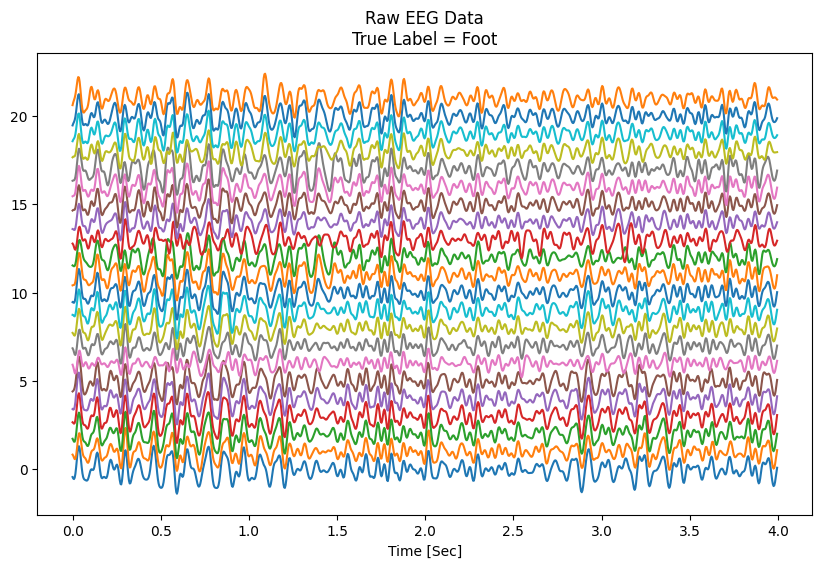

In [10]:
# Plot the Data
# Show a shifted and scaled channels at a single plot.
# You may run it several times to observe different measurements.

numSamples, numMeasurements, numChannels = mX.shape #<! Samples, Time Samples, Channels
idx     = np.random.randint(numSamples)
mXi     = mX[idx, :, :].copy()
yi      = vY[idx]

# Normalizing and Vertically Shifting
mXi -= mXi.mean(0)
mXi /= 20
mXi += np.arange(numChannels)[None, :]
vT   = np.linspace(0, 4, numMeasurements, endpoint = False)

hF, hA = plt.subplots(figsize = (10, 6))
hA.plot(vT, mXi)
hA.set_title (f'Raw EEG Data\nTrue Label = {lLabel[yi]}')
hA.set_xlabel('Time [Sec]')

plt.show()

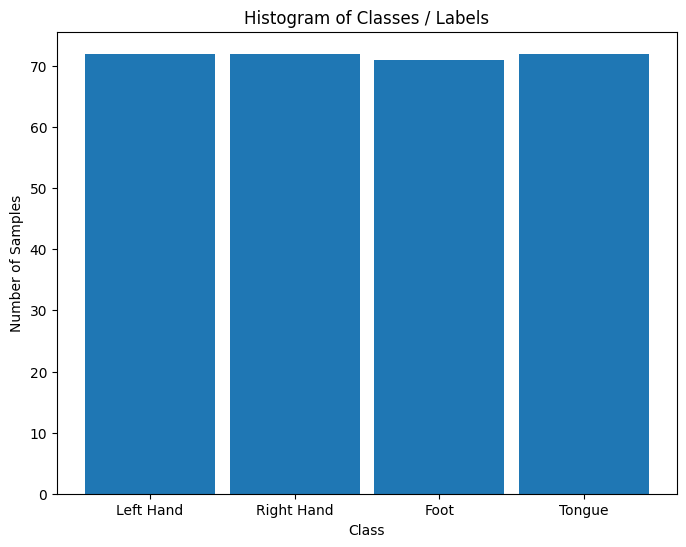

In [11]:
# Histogram of Labels

hA = PlotLabelsHistogram(vY, lClass = lLabel)

* <font color='brown'>(**#**)</font> The data is balanced.

### 9.1. Processing RAW Data

In this section we'll compare 4 dimensionality reduction methods:

 - IsoMap.
 - MDS.
 - t-SNE.
 - UMAP.

We'll reduce the data dimension to `d = 2` and use the reference labels to display result.

The steps:

1. Data Pre Processing  
     * Reshape data into `mXRaw` such that each measurement is a row.  
       Namely the data should have dimensions of `287 x 22_000`.  
     * Apply dimensionality reduction using PCA to keep most of the data energy.
2. Set Parameters  
   Set parameters of each method to get results.  
   Set the amount of energy preserved using the PCA pre processing.
   **No need for grid search, just try and error of few values**.
3. Apply the Transform  
   Apply the transform on the data.  
   The low dimensional data should be in 2D space.  
4. Display Results  
   Create a subplot per method showing the results and the used parameters.  

* <font color='brown'>(**#**)</font> No need to self implement any of the methods. You should use SciKit Learn's implementations.

C:\Users\Ori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Ori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\Ori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in 

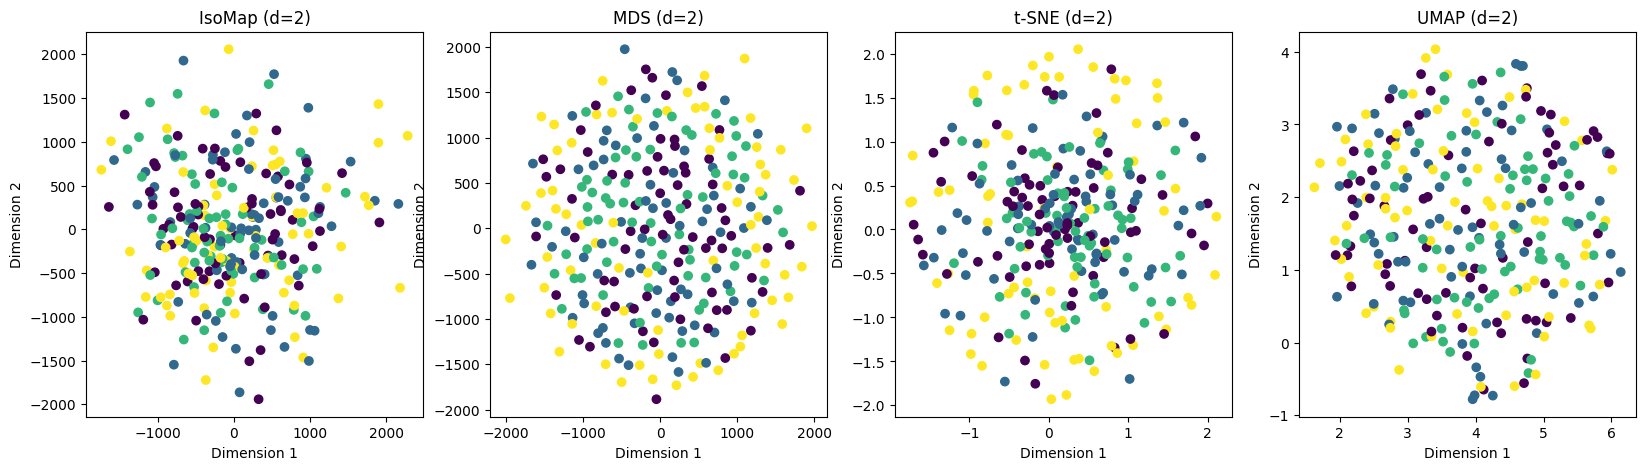

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, TSNE
import umap

# 1. Pre Process data
# Reshape to (287 x 22,000).
# Apply PCA to preserve `relEnergy` of the energy.

# Reshape the data into (287 x 22,000)
mX_reshaped = mX.reshape(287, 22000)

# Apply PCA to keep most of the data energy (adjust the value of n_components)
relEnergy = 0.95  # Adjust this value based on desired energy preservation
pca = PCA(n_components=relEnergy)
mX_pca = pca.fit_transform(mX_reshaped)

# 2. Apply Dimensionality Reduction (d = 2) using IsoMap, MDS, t-SNE, and UMAP
# Choose reasonable parameters for each method

# IsoMap
isomap = Isomap(n_neighbors=10, n_components=2)  # Set appropriate values
mX_isomap = isomap.fit_transform(mX_reshaped)

# MDS
mds = MDS(n_components=2, n_init = 1, max_iter = 100, metric=True)  # Set appropriate values
mX_mds = mds.fit_transform(mX_reshaped)

# t-SNE
tsne = TSNE(n_components=2, perplexity=100, n_iter=1000)  # Adjust parameters as needed
mX_tsne = tsne.fit_transform(mX_reshaped)

# UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.1)  # Adjust parameters
mX_umap = umap_model.fit_transform(mX_reshaped)

# 3. Display the Low Dimensionality data
# Include the parameters in the title of each method.
# Create a figure with subplots (1x4) for each method

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
methods = ["IsoMap", "MDS", "t-SNE", "UMAP"]
data = [mX_isomap, mX_mds, mX_tsne, mX_umap]

for i, ax in enumerate(axes):
    ax.scatter(data[i][:, 0], data[i][:, 1], c=vY, cmap='viridis')
    ax.set_title(f'{methods[i]} (d=2)')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

plt.show()


### 9.1.1 Question

1. What's the purpose of the PCA pre process?
2. Explain the results. Think in the context of being able to classify the body part in action.

### 9.1.1 Solution

1. Purpose of PCA Preprocessing:

The purpose of PCA (Principal Component Analysis) preprocessing in this context is to reduce the dimensionality of the EEG data while preserving most of its energy. This serves several purposes:

        Dimensionality Reduction: EEG data is typically high-dimensional, with many channels and measurements. High dimensionality can lead to computational complexity and may require more data to model effectively. PCA reduces this high-dimensional data to a lower-dimensional representation while retaining as much useful information as possible.

        Noise Reduction: By focusing on the principal components that capture the most variation in the data, PCA can help reduce noise and emphasize the underlying patterns or features that are relevant for analysis.

        Visualization: PCA provides a way to visualize high-dimensional data in a lower-dimensional space, making it easier to explore and understand the data. In this case, reducing the data to 2D allows for visualization of EEG data in a 2D scatter plot.

2. Explanation of Results:

The results of dimensionality reduction using IsoMap, MDS, t-SNE, and UMAP can be interpreted as follows:

        IsoMap: IsoMap aims to preserve the geodesic distances between data points in the lower-dimensional space. As a result, it can reveal the intrinsic structure of the data. In the context of classifying body parts in action, you might observe clusters of data points corresponding to different actions. If the clustering is clear, it suggests that the actions have distinct patterns in the EEG data.

        MDS (Multi-Dimensional Scaling): MDS tries to preserve pairwise distances between data points. If the MDS plot shows clear separation between classes (body parts), it indicates that the EEG patterns associated with different body parts are distinct.

        t-SNE (t-Distributed Stochastic Neighbor Embedding): t-SNE is effective at capturing local structure in the data, meaning that similar data points tend to be close to each other in the lower-dimensional space. In the context of body part classification, if t-SNE results in tight clusters for each body part, it suggests that the EEG patterns are discriminative.

        UMAP (Uniform Manifold Approximation and Projection): UMAP is similar to t-SNE but offers greater control over the balance between preserving local and global structure. Clear separation of body parts in a UMAP plot indicates that the method has captured meaningful patterns.

Overall, the goal of these dimensionality reduction techniques is to transform the high-dimensional EEG data into a lower-dimensional space where differences between body parts are visually apparent. The effectiveness of these methods can be assessed by examining whether they produce distinct clusters or groupings for different body parts, which would aid in their classification.

---

### 9.2. Feature Engineering

Form the above it is clear the RAW measurements are not a good representation of the data.  
Since each sample is basically $\boldsymbol{X}_{i}\in\mathbb{R}^{1000 \times 22}$ we can work on the time axis of the data.  

The strategy is as following:

 * Use the Covariance Matrix is a feature of the sample.
 * Use a metric optimized to covariance matrices.

Do the following steps:

1. Implements `GenCovMat()`  
   For each sample $\boldsymbol{X}_{i}\in\mathbb{R}^{1000 \times 22}$, compute the covariance matrix $\boldsymbol{C}_{i}\in\mathbb{R}^{22\times22}$.  
   You may use [`np.cov()`](https://numpy.org/doc/stable/reference/generated/numpy.cov.html).
2. Implement `SpdMetric()`  
   Given 2 SPD matrices in the form of vectors computes the geodesic distance between them.
3. Apply the Feature Engineering  
   The end of this process should be a matrix `mZ` with dimensions (287 x 22^2)
4. Generate the Distance Matrix  
   Using `SpdMetric()` generate the distance matrix of the data.  
   The output should be a matrix `mD` with dimensions (287 x 287).

#### The SPD Matrices Metric

An optimized metric for the manifold of SPD Matrices, is given by the SPD Metric (`SpdMetric`):

$$d\left(\boldsymbol{C}_{i},\boldsymbol{C}_{j}\right)=\sqrt{\sum_{i=1}^{d}\log^{2}\left(\lambda_{i}\left(\boldsymbol{C}_{i}^{-1}\boldsymbol{C}_{j}\right)\right)}$$

Where ${\lambda}_{i} \left( \cdot \right)$ extract the $i$ -th eigen value of the matrix.

In [13]:
def GenCovMat(mX: np.ndarray) -> np.ndarray:
    '''
    Calculates the covariance matrices of the input data.
    Args:
        mX - Input data with shape (N x T x C)
    Output:
        mC - N covariance matrices with shape (N x C x C)
    '''

    # 1. Calculate the covariance matrices array.
    # Use np.cov to calculate the covariance matrices for each sample in mX
    # Make sure to set rowvar=False to treat each column as a variable

    mC = np.array([np.cov(sample, rowvar=False) for sample in mX])

    return mC


In [14]:
def SpdMetric(vP: np.ndarray, vQ: np.ndarray) -> float:
    '''
    Calculates the AIRM geodesic distance between two SPD matrices.
    Args:
        vP    - An SPD matrix in the form of a vector with shape (d^2, )
        vQ    - An SPD matrix in the form of a vector with shape (d^2, )
    Output:
        geoDist - The geodesic distance, dist ≥ 0
    '''

    # 1. Convert the vectors into a matrix.
    # Reshape the vectors into square matrices.
    d = int(np.sqrt(vP.shape[0]))
    mP = vP.reshape(d, d)
    mQ = vQ.reshape(d, d)

    # 2. Calculate the geodesic distance of SPD matrices.
    eigenvalues = eigvalsh(mP, mQ)

    # Calculate the geodesic distance
    geoDist = np.sqrt(np.sum(np.log(eigenvalues) ** 2))

    return geoDist


In [15]:
# Process Data

#===========================Fill This===========================#
# 1. Generate the covariance matrices.
# 2. Reshape data into the samples matrix.
# 3. Calculate the distance matrix.
# !! Don't use any loop!
# !! You may use `pairwise_distances()` in order to avoid loops.

from sklearn.metrics import pairwise_distances

# 1. Generate the covariance matrices.
mC = GenCovMat(mX)

# 2. Reshape data into the samples matrix.
mc_R = mC.reshape(287, 484)

# 3. Calculate the distance matrix.
# Use pairwise_distances to calculate the pairwise distances between samples
mD = pairwise_distances(mc_R, metric=SpdMetric)

#===============================================================#


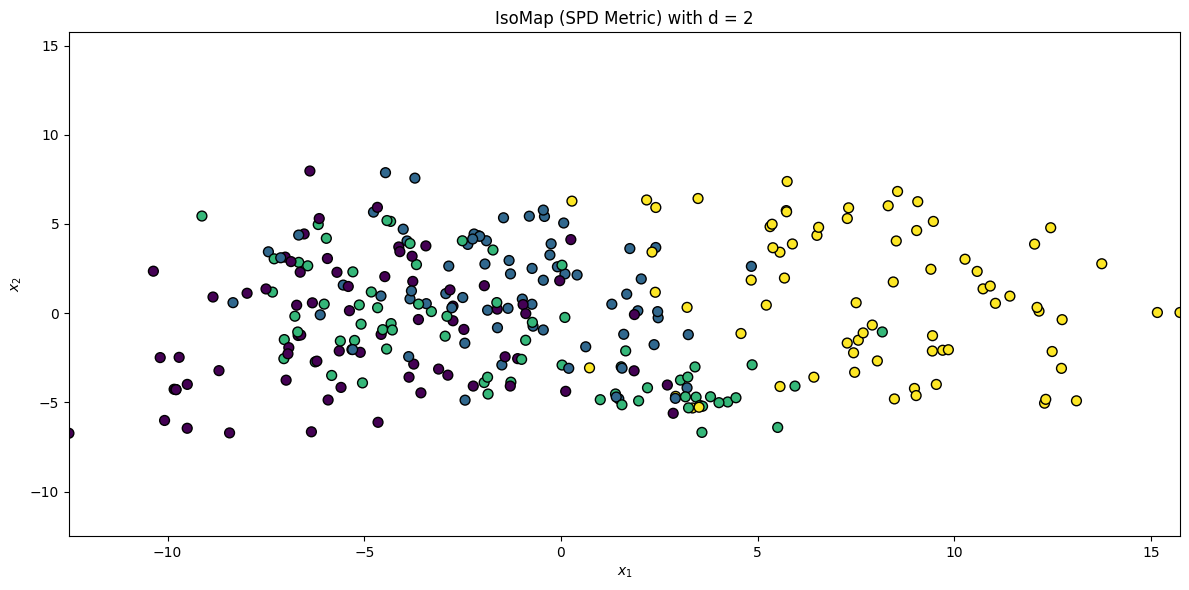

In [16]:
# Plot the Low Dimensional Data
# This shows the result using IsoMap with SpdMetric.

d = 2
oIsoMapDr = Isomap(n_neighbors = 3, n_components = d, metric = 'precomputed')

hF = plt.figure(figsize = (12, 6))
    
mZi = oIsoMapDr.fit_transform(mD)
hA = hF.add_subplot()
Plot2DScatter(mZi, hA, vY)
hA.set_title(f'IsoMap (SPD Metric) with d = {d}')

plt.tight_layout()
plt.show()



#### 9.2.1. Question

In the above the _IsoMap_ is used.  
If one would like to use SciKit Learn's _Spectral Embedding_ (See [`SpectralEmbedding`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html)) one need to supply _Affinity Matrix_ (See `affinity` parameter).  
Describe how would you generate such matrix based on `SpdMetric()`.

* <font color='brown'>(**#**)</font> SciKit Learn's _Spectral Embedding_ is equivalent to _Laplacian Eigenmaps_ on lecture notes.

#### 9.2.1. Solution


To generate an affinity matrix for SciKit Learn's SpectralEmbedding based on the SpdMetric() function, follow these steps:

Calculate Pairwise Distances: Compute the pairwise distances between SPD matrices using the pairwise_distances() function with the SpdMetric metric. This will create a matrix of distances between all pairs of SPD matrices.

Define Similarity Measure: In spectral embedding, we require an affinity matrix that represents similarity instead of distance. To achieve this, convert the distances into similarities using a Gaussian similarity measure:

similarity_ij = exp(-gamma * distance_ij^2)
Here, distance_ij denotes the pairwise distance between SPD matrices i and j, and gamma is a scaling parameter that controls the width of the Gaussian. Adjust the gamma value based on the dataset's characteristics.

Create Affinity Matrix: Construct the affinity matrix by using the similarity values computed in step 2. Ensure that the affinity matrix is symmetric, with each element representing the similarity between two SPD matrices.

---

### 9.3. Dimensionality Reduction and Classification on Engineered Data

In this section we'll focus on `t-SNE` and `UMAP`.  

1. Apply Dimensionality Reduction  
   Apply `t-SNE` and / or `UMAP` on the engineered data.  
   Make sure to use the appropriate options to utilize the metric.  
   Apply this on the whole data.
2. Apply Classification  
   Apply a classifier (From SciKit Learn, Neural Networks excluded) on the low dimensional data.
3. Measure Performance of the Classifier  
   Apply **leave one out cross validation** with score based on **accuracy**.  
   You should use [`cross_val_predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html).  
   This will generate a vector of 287 predictions.
4. Display Results  
   Display the confusion matrix and the total accuracy.

**This is a competition**: 
 
 * The group with the 1st highest score will get 4 bonus points.
 * The group with the 2nd highest score will get 2 bonus points.


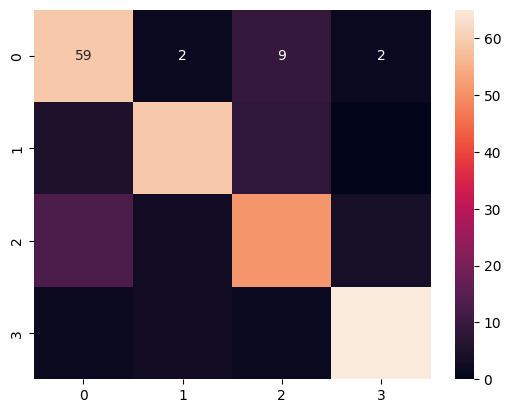

Total accuracy:  0.8153310104529616


In [17]:
#===========================Fill This===========================#
# 1. Use t-SNE and/or UMAP for Dimensionality Reduction.
# 2. On the output of (1) apply a classifier from SciKit Learn.
# 3. To measure the performance use `cross_val_predict()` with accuracy as the score.
# 4. Display the confusion matrix of the result of the `cross_val_predict()`.
# !! Use leave one out as the validation policy.
# !! Use the `SpdMetric()` for UMAP / t-SNE!
# !! This is a competition, optimize the hyper parameters of each step for best accuracy.
# !! No use of Neural Net based classifiers!
# !! If you use t-SNE, make sure to make it non random (See `init` and `random_state`).
# !! Pay attention to the run time limitation of the whole notebook.

reducer = TSNE(init='pca', random_state=0)

lower_dim_results = reducer.fit_transform(mD)

clf = RandomForestClassifier(random_state=0)

loo = LeaveOneOut()

predictions = cross_val_predict(clf, lower_dim_results, vY, cv = loo)
accuracy = accuracy_score(vY, predictions)


matrix = confusion_matrix(vY, predictions)

sns.heatmap(matrix, annot=True)
plt.show()

print('Total accuracy: ', accuracy)

#===============================================================#

#### 9.3.1. Question

In the above we had the whole data for the _dimensionality reduction_ step.  
Assume we use a method without _out of sample extension_.  
In the case above, how would you handle a new data point? Explain the pipeline.

#### 9.3.1. Solution


If we use a dimensionality reduction method without out-of-sample extension (such as t-SNE or UMAP), handling a new data point would require us to follow a specific pipeline:

1. Retrain the Dimensionality Reduction Model: When a new data point arrives, we need to retrain the dimensionality reduction model using the entire dataset (including the new data point). This step ensures that the new data point is embedded into the existing lower-dimensional space consistently with the rest of the data.

2. Apply the Dimensionality Reduction Model: Once the dimensionality reduction model is retrained, we can apply it to the new data point to obtain its lower-dimensional representation. This representation will be consistent with the lower-dimensional space of the existing dataset.

3. Use the Classifier: After obtaining the lower-dimensional representation of the new data point, we can then use the trained classifier to make predictions or perform classification tasks on the new data point. The classifier should be able to operate in the lower-dimensional space.

Some key points to remember:

- Retraining the dimensionality reduction model is necessary because these techniques don't inherently support out-of-sample extension. They work by optimizing embeddings for the specific dataset they were trained on.

- The lower-dimensional space obtained from the retrained model should align with the space in which the classifier was originally trained. This alignment ensures that the classifier can effectively make predictions on the new data point.

- It's important to maintain consistency in preprocessing steps (e.g., feature scaling or any other data transformations) between the existing dataset and the new data point to ensure accurate embeddings and predictions.

-  Depending on the complexity and runtime constraints, it may be necessary to periodically retrain the dimensionality reduction model on the entire dataset, especially if new data points are added frequently.

Overall, handling new data points with dimensionality reduction methods that lack out-of-sample extension capabilities can be computationally intensive, especially for large datasets. The key is to ensure that the lower-dimensional space remains consistent and meaningful when embedding new data points.

---

In [18]:
# Run Time
# Check Total Run Time.
# Don't change this!

endTime = time.time()

totalRunTime = endTime - startTime
print(f'Total Run Time: {totalRunTime} [Sec].')

if (totalRunTime > TOTAL_RUN_TIME):
    raise ValueError(f'You have exceeded the allowed run time as {totalRunTime} > {TOTAL_RUN_TIME}')

Total Run Time: 41.911170959472656 [Sec].
